Agave on Python

In [1]:
!mkdir -p ~/agave

In [2]:
%cd ~/agave

/home/sbrandt/agave


In [3]:
import re
import os
import sys
from setvar import *

In [4]:
setvar("""
MACHINE=shelob
DOMAIN=hpc.lsu.edu
EMAIL=sbrandt@cct.lsu.edu
AGAVE_USERNAME=stevenrbrandt
MACHINE_USERNAME=sbrandt
BASE_APP_NAME=drawgau
PORT=22
ALLOCATION=hpc_hyrel17

WORK_DIR=/work/${MACHINE_USERNAME}
HOME_DIR=/home/${MACHINE_USERNAME}
SCRATCH_DIR=/work/${MACHINE_USERNAME}
DEPLOYMENT_PATH=agave-deployment
MACHINE_FULL=${MACHINE}.${DOMAIN}
AGAVE_JSON_PARSER=jq
PATH=$HOME/agave/cli/bin:$PATH
""")

MACHINE=shelob
DOMAIN=hpc.lsu.edu
EMAIL=sbrandt@cct.lsu.edu
AGAVE_USERNAME=stevenrbrandt
MACHINE_USERNAME=sbrandt
BASE_APP_NAME=drawgau
PORT=22
ALLOCATION=hpc_hyrel17
WORK_DIR=/work/sbrandt
HOME_DIR=/home/sbrandt
SCRATCH_DIR=/work/sbrandt
DEPLOYMENT_PATH=agave-deployment
MACHINE_FULL=shelob.hpc.lsu.edu
AGAVE_JSON_PARSER=jq
PATH=/home/sbrandt/agave/cli/bin:/usr/local/bin/anaconda2/bin:/root/anaconda2/bin:/usr/local/bin/anaconda2/bin:/root/anaconda2/bin:/usr/local/sbin:/usr/local/bin:/sbin:/bin:/usr/sbin:/usr/bin:/root/bin


In [10]:
readpass("AGAVE_PASSWD")

Password or secret: AGAVE_PASSWD
Reading file `AGAVE_PASSWD.txt'


In [8]:
readpass("HPC_PASSWD")

Password or secret: HPC_PASSWD
Reading file `HPC_PASSWD.txt'


In [6]:
readpass("PBTOK")

Password or secret: PBTOK
Reading file `PBTOK.txt'


In [11]:
setvar("APP_NAME=${BASE_APP_NAME}-${MACHINE}-${AGAVE_USERNAME}")

APP_NAME=drawgau-shelob-stevenrbrandt


In [ ]:
!git clone https://bitbucket.org/agaveapi/cli.git

In [12]:
!tenants-init -t agave.prod

You are now configured to interact with the APIs at https://public.agaveapi.co/


In [13]:
!echo "$AGAVE_PASSWD"| clients-delete -u $AGAVE_USERNAME $APP_NAME

API password: stty: standard input: Inappropriate ioctl for device
stty: standard input: Inappropriate ioctl for device

Successfully deleted client drawgau-shelob-stevenrbrandt


In [14]:
!clients-delete -u $AGAVE_USERNAME -p "$AGAVE_PASSWD" $APP_NAME

Successfully deleted client drawgau-shelob-stevenrbrandt


In [15]:
!clients-create -p "$AGAVE_PASSWD" -S -N $APP_NAME -u $AGAVE_USERNAME

Successfully created client drawgau-shelob-stevenrbrandt
key: h9LAf9onbxL0ZbrFmm27fWBhSYka 
secret: P6XdMo2naq4IO2wLLrrhr05tsG8a


In [16]:
!auth-tokens-create -u $AGAVE_USERNAME -p "$AGAVE_PASSWD"

Token for agave.prod:stevenrbrandt successfully refreshed and cached for 14400 seconds
ea7d76846d2b9d165877256dce1f94b


In [18]:
!ssh-keygen -y -f ${MACHINE}-key -N "" < /dev/null

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCoCP8y1eWAo982Oneb/wwtpBFcuk2cl1FjFkoZ/bhn6Mh+bcpUJMtOSP37pgbuSI0+xT2wOCdN2SUyaEUwvvqSf5N+1Z4otCXvb7LLECop5GHlC21MMozBXL5qn+F2YYz/j57eEs9zzCsDDuB8ETkYFGGuCfswJKTU5Pc0Avh9C+eOXi2U5WEbXPm+AhOpMcPM3t4Uju0hKvxzsSmlf4z3BVVOJ1MehgLe0s+y24DRl8gjz4IAPNPs3gs1o42fOZwS1ZJvjsJI+Uwxi23H1YuZWAbk3mAiCtU4Naza0lHyWTVr5X9MYC5DTcflLiFYEe0Mh8jlx0rPm/T0Q5DYx30H


In [19]:
!chmod 600 ${MACHINE}-key

In [ ]:
!cat ~/agave/${MACHINE}-key.pub | sshpass -f ~/hpc_pw.txt ssh ${MACHINE_USERNAME}@${MACHINE_FULL} sh -c "cat - >> ~/.ssh/authorized_keys"

In [20]:
!ssh -o "StrictHostKeyChecking=no" -o "IdentitiesOnly=yes" -o "BatchMode=yes" \
    -o "IdentityFile=${MACHINE}-key" ${MACHINE_USERNAME}@${MACHINE_FULL} -p ${PORT} \
  echo Key is installed

Key is installed


In [21]:
!jsonpki --public ${MACHINE}-key.pub > ${MACHINE}-key.pub.txt
!jsonpki --private ${MACHINE}-key > ${MACHINE}-key.txt

In [22]:
!auth-tokens-refresh

Token for agave.prod:stevenrbrandt successfully refreshed and cached for 14400 seconds
c755d8f2aef8e9e8667366546acca3


In [23]:
os.environ["PUB_KEY"]=readfile("${MACHINE}-key.pub.txt").strip()
os.environ["PRIV_KEY"]=readfile("${MACHINE}-key.txt").strip()

Reading file `shelob-key.pub.txt'
Reading file `shelob-key.txt'


In [24]:
setvar("STORAGE_MACHINE=${MACHINE}-storage-${AGAVE_USERNAME}")

STORAGE_MACHINE=shelob-storage-stevenrbrandt


In [25]:
writefile("${STORAGE_MACHINE}.txt","""{
    "id": "${STORAGE_MACHINE}",
    "name": "${MACHINE} storage (${MACHINE_USERNAME})",
    "description": "The ${MACHINE} computer",
    "site": "${DOMAIN}",
    "type": "STORAGE",
    "storage": {
        "host": "${MACHINE_FULL}",
        "port": ${PORT},
        "protocol": "SFTP",
        "rootDir": "/",
        "homeDir": "${HOME_DIR}",
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        }
    }
}
""")

Writing file `shelob-storage-stevenrbrandt.txt'


In [26]:
!systems-addupdate -F ${STORAGE_MACHINE}.txt

Successfully added system shelob-storage-stevenrbrandt


In [27]:
!files-list -S ${STORAGE_MACHINE} ./ | head -5

.
.bash_history
.bash_history3
.bash_logout
.bash_profile


In [28]:
# Assuming ${MACHINE} uses torque as a queuing system, this will get info about the queues
# The command you need to use to list the queue information varies from system to system.
# For Torque, the command is "qstat -q."
!ssh -o "IdentityFile=${MACHINE}-key" ${MACHINE_USERNAME}@${MACHINE_FULL} -p ${PORT} qstat -q 


server: mike3

Queue            Memory CPU Time Walltime Node  Run Que Lm  State
---------------- ------ -------- -------- ----  --- --- --  -----
workq              --      --    72:00:00   128  43   6 --   E R
mwfa               --      --    72:00:00     8   0   0 --   E R
bigmem             --      --    168:00:0     1   0   0 --   E R
westmere           --      --    168:00:0     1   0   0 --   E R
lasigma            --      --    72:00:00    28   0   0 --   E R
bigmemtb           --      --    48:00:00     1   0   1 --   E R
priority           --      --    168:00:0   128   0   0 --   E R
single             --      --    72:00:00     1  11  42 --   E R
gpu                --      --    72:00:00    16   2   0 --   E R
preempt            --      --    72:00:00   --    0   0 --   E R
checkpt            --      --    72:00:00   128  50   8 --   E R
admin              --      --    24:00:00   --    0   0 --   E R
scalemp            --      --    24:00:00     1   0   0 --   E R
shelob 

In [29]:
setvar("""
# Gather info about the machine
# Executing this cell is essential
MAX_TIME=72:00:00 # Max duration of a job
# We figure out the number of processes automatically.
# This assumes the head node and compute nodes have
# the same number of procs.
CPUINFO=$(ssh -o "IdentityFile=${MACHINE}-key" ${MACHINE_USERNAME}@${MACHINE_FULL} -p ${PORT} lscpu)
QUEUE=shelob # Name of default queue
NODES=42 # Number of nodes in queue
""")
g = re.search(r'(?m)CPU\(s\):\s*(\d+)',os.environ["CPUINFO"])
os.environ["PROCS"]=g.group(1)
print(repvar("PROCS=$PROCS"))

MAX_TIME=72:00:00
CPUINFO=Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 45
Model name:            Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz
Stepping:              7
CPU MHz:               1200.000
BogoMIPS:              5199.24
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              20480K
NUMA node0 CPU(s):     0-7
NUMA node1 CPU(s):     8-15
QUEUE=shelob
NODES=42
PROCS=16


In [30]:
setvar("EXEC_MACHINE=${MACHINE}-exec-${AGAVE_USERNAME}")

EXEC_MACHINE=shelob-exec-stevenrbrandt


In [31]:
os.environ["DIRECTIVES"]=re.sub("\n\\s*",r"\\n","""
#PBS -A ${ALLOCATION}
#PBS -l cput=\${AGAVE_JOB_MAX_RUNTIME}
#PBS -l walltime=\${AGAVE_JOB_MAX_RUNTIME}
#PBS -q \${AGAVE_JOB_BATCH_QUEUE}
#PBS -l nodes=\${AGAVE_JOB_NODE_COUNT}:ppn=16
""".strip())

In [32]:
os.environ["DIRECTIVES"]

'#PBS -A ${ALLOCATION}\\n#PBS -l cput=\\${AGAVE_JOB_MAX_RUNTIME}\\n#PBS -l walltime=\\${AGAVE_JOB_MAX_RUNTIME}\\n#PBS -q \\${AGAVE_JOB_BATCH_QUEUE}\\n#PBS -l nodes=\\${AGAVE_JOB_NODE_COUNT}:ppn=16'

In [33]:
# Edit any parts of this file that you know need to be changed for your machine.
writefile("${EXEC_MACHINE}.txt","""
{
    "id": "${EXEC_MACHINE}",
    "name": "${MACHINE} (${MACHINE_USERNAME})",
    "description": "The ${MACHINE} computer",
    "site": "${DOMAIN}",
    "public": false,
    "status": "UP",
    "type": "EXECUTION",
    "executionType": "HPC",
    "scheduler" : "CUSTOM_TORQUE",
    "environment": null,
    "scratchDir" : "${SCRATCH_DIR}",
    "queues": [
        {
            "customDirectives" : "${DIRECTIVES}",
            "name": "${QUEUE}",
            "default": true,
            "maxJobs": 10,
            "maxUserJobs": 10,
            "maxNodes": ${NODES},
            "maxProcessorsPerNode": ${PROCS},
            "minProcessorsPerNode": 1,
            "maxRequestedTime": "${MAX_TIME}"
        }
    ],
    "login": {
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        },
        "host": "${MACHINE_FULL}",
        "port": ${PORT},
        "protocol": "SSH"
    },
    "maxSystemJobs": 50,
    "maxSystemJobsPerUser": 50,
    "storage": {
        "host": "${MACHINE_FULL}",
        "port": ${PORT},
        "protocol": "SFTP",
        "rootDir": "/",
        "homeDir": "${HOME_DIR}",
        "auth": {
          "username" : "${MACHINE_USERNAME}",
          "publicKey" : "${PUB_KEY}",
          "privateKey" : "${PRIV_KEY}",
          "type" : "SSHKEYS"
        }
    },
    "workDir": "${WORK_DIR}"
}""")

Writing file `shelob-exec-stevenrbrandt.txt'


In [34]:
!systems-addupdate -F ${EXEC_MACHINE}.txt

Successfully added system shelob-exec-stevenrbrandt


In [35]:
# Test to see if this worked...
!files-list -S ${EXEC_MACHINE} ./ | head -5

.
.bash_history
.bash_history3
.bash_logout
.bash_profile


In [36]:
writefile("drawgau-wrapper.txt","""
#!/bin/bash
echo 'Executing Draw Gau Code'
# Setting the x flag will echo every
# command onto stderr. This is
# for debugging, so we can see what's
# going on.
set -x
echo ==ENV=============
# The env command prints out the
# entire execution environment. This
# is also present for debugging purposes.
env
echo ==PWD=============
# We also print out the execution
# directory. Again, for debugging purposes.
pwd
echo ==JOB=============
EXE_DIR=/home/${MACHINE_USERNAME}/drawgau
# \${parfile} will be substituted by Agave
# I like having my environment variables in
# upper case, that's the only reason for this
# assignment.
FAIL=no
if [ "\${parfile}" = "" ]
then
  echo "The parfile was not set"
  # Note: Job failure must be explicitly reported to
  # the Agave framework, otherwise it might
  # mistakenly believe the job is still running.
  $(${AGAVE_JOB_CALLBACK_FAILURE})
  exit 1
fi
if [ "\${PBS_NODEFILE}" = "" ]
then
  # When running on a system managed by Torque
  # this variable should be set. If it's not,
  # that's a problem.
  echo "The PBS_NODEFILE was not set"
  $(${AGAVE_JOB_CALLBACK_FAILURE})
  exit 2
fi

# By default, the PBS_NODEFILE lists nodes multiple
# times, once for each MPI process that should run
# there. We only want one MPI process per node, so
# we create a new file with "sort -u".
LOCAL_NODEFILE=nodefile.txt
sort -u < \${PBS_NODEFILE} > \${LOCAL_NODEFILE}
PROCS=\$(wc -l < \${LOCAL_NODEFILE})

if [ "\${PROCS}" = "" ]
then
  echo "PROCS was not set"
  \$(\${AGAVE_JOB_CALLBACK_FAILURE})
  exit 3
fi

# Execute our MPI command.
mpirun -np \${PROCS} -machinefile \${LOCAL_NODEFILE} \${EXE_DIR}/drawgau \${parfile}
""")

Writing file `drawgau-wrapper.txt'


In [37]:
!files-mkdir -S ${STORAGE_MACHINE} -N ${DEPLOYMENT_PATH}
!files-upload -F drawgau-wrapper.txt -S ${STORAGE_MACHINE} ${DEPLOYMENT_PATH}/

Successfully created folder agave-deployment
Uploading drawgau-wrapper.txt...
######################################################################## 100.0%


In [38]:
writefile("test.txt","""
parfile="input.txt"
drawgau-wrapper.txt
""")

Writing file `test.txt'


In [39]:
!files-mkdir -S ${STORAGE_MACHINE} -N ${DEPLOYMENT_PATH}
!files-upload -F test.txt -S ${STORAGE_MACHINE} ${DEPLOYMENT_PATH}/

Successfully created folder agave-deployment
Uploading test.txt...
######################################################################## 100.0%


In [40]:
writefile("${APP_NAME}.txt","""
{  
   "name":"${APP_NAME}",
   "version":"1.0",
   "label":"Draw Gaussian Curve",
   "shortDescription":"Just draws a Gaussian",
   "longDescription":"",
   "deploymentSystem":"${STORAGE_MACHINE}",
   "deploymentPath":"${DEPLOYMENT_PATH}",
   "templatePath":"drawgau-wrapper.txt",
   "testPath":"test.txt",
   "executionSystem":"${EXEC_MACHINE}",
   "executionType":"HPC",
   "parallelism":"SERIAL",
   "allocation":"${ALLOCATION}",
   "modules":[],
   "inputs":[
         {   
         "id":"parfile",
         "details":{  
            "label":"Draw Gau Parameter File: ",
            "description":"",
            "argument":null,
            "showArgument":false
         },
         "value":{  
            "default":"testInput.txt",
            "order":0,
            "required":true,
            "validator":"",
            "visible":true
         }
      }   

   ],
   "parameters":[],
   "outputs":[  
      {  
         "id":"Output",
         "details":{  
            "description":"The output",
            "label":"x y file"
         },
         "value":{  
            "default":"drawgau.txt",
            "validator":""
         }
      }
   ]
}
""")

Writing file `drawgau-shelob-stevenrbrandt.txt'


In [41]:
!apps-addupdate -F ${APP_NAME}.txt

Successfully added app drawgau-shelob-stevenrbrandt-1.0


In [42]:
writefile("drawgau.cpp","""
#include <mpi.h>
#include <iostream>
#include <fstream>
#include <sstream>
#include <math.h>
#include <stdlib.h>

using namespace std;

void usage() {
  std::cerr << "usage: drawgau input.txt" << std::endl;
  exit(1);
}

int main(int argc, char **argv) {
  if(argc != 2)
    usage();
  ifstream i(argv[1]);

  if(!i.good())
    usage();

  MPI_Init(&argc,&argv);
  int rank,size;
  MPI_Comm_rank(MPI_COMM_WORLD,&rank);
  MPI_Comm_size(MPI_COMM_WORLD,&size);

  double minx, maxx, delx;
  i >> minx >> maxx >> delx;
  if(rank == 0) {
    cout << "minx=" << minx << endl;
    cout << "maxx=" << maxx << endl;
    cout << "delx=" << delx << endl;
    cout << "mpi size=" << size << endl;
  }

  stringstream s;
  s << "drawgau" << rank << ".txt";
  string fname = s.str();
  cout << "FILE: " << fname << endl;
  ofstream f(fname,ofstream::out);
  double delxp = (maxx - minx)/size;
  double minxp = minx+delxp*rank;
  double maxxp = minxp + delxp;
  cout << "rank=" << rank << " minxp=" << minxp << " maxxp=" << maxxp << endl;
  for(double x = minxp; x < maxxp; x += delx) {
    f << x << " " << exp(-x*x) << endl;
  }
  f.close();
  MPI_Finalize();
  return 0;
}
""")

Writing file `drawgau.cpp'


In [43]:
writefile("build.sh","""
#!/bin/bash
set -x
cd ~/drawgau
mpicxx -std=c++11 -o drawgau drawgau.cpp
""")

Writing file `build.sh'


In [44]:
writefile("input.txt","-1 1 .01")

Writing file `input.txt'


In [45]:
!files-mkdir -S ${STORAGE_MACHINE} -N drawgau
!files-upload -F drawgau.cpp -S ${STORAGE_MACHINE} drawgau/
!files-upload -F build.sh -S ${STORAGE_MACHINE} drawgau/
!files-upload -F input.txt -S ${STORAGE_MACHINE} drawgau/
!ssh -o "IdentityFile=${MACHINE}-key" ${MACHINE_USERNAME}@${MACHINE_FULL} -p ${PORT} bash --login ./drawgau/build.sh

Successfully created folder drawgau
Uploading drawgau.cpp...
######################################################################## 100.0%
Uploading build.sh...
######################################################################## 100.0%
Uploading input.txt...
######################################################################## 100.0%
+ cd /home/sbrandt/drawgau
+ mpicxx -std=c++11 -o drawgau drawgau.cpp


In [46]:
writefile("job.txt","""
{
  "name":"test-jobc-1",
  "appId": "${APP_NAME}-1.0",
  "executionSystem": "${EXEC_MACHINE}",
  "batchQueue": "${QUEUE}",
  "maxRunTime": "${MAX_TIME}",
  "nodeCount": 2,
  "processorsPerNode": 2,
  "archive": false,
  "archiveSystem": "${STORAGE_MACHINE}",
  "inputs": {
    "parfile": "agave://${STORAGE_MACHINE}/${HOME_DIR}/drawgau/input.txt"
  },
  "parameters": {
  },
  "notifications": [
    {
      "url":"${EMAIL}",
      "event":"FINISHED",
      "persistent":false
    },
    {
      "url":"${EMAIL}",
      "event":"FAILED",
      "persistent":false
    },
    {
      "url":"https://www.cct.lsu.edu/~sbrandt/pushbullet.php?key=${PBTOK}&status=\${JOB_STATUS}:\${JOB_ID}",
      "event":"FINISHED",
      "persistent":"false"
    },
    {
      "url":"https://www.cct.lsu.edu/~sbrandt/pushbullet.php?key=${PBTOK}&status=\${JOB_STATUS}:\${JOB_ID}",
      "event":"FAILED",
      "persistent":"false"
    }
  ]
}
""")

Writing file `job.txt'


In [47]:
setvar("""
# Capture the output of the job submit command
OUTPUT=$(jobs-submit -F job.txt)
# Parse out the job id from the output
JOB_ID=$(echo $OUTPUT | cut -d' ' -f4)
""")

OUTPUT=Successfully submitted job 251542905577345511-242ac11b-0001-007
JOB_ID=251542905577345511-242ac11b-0001-007


In [50]:
from time import sleep
for iter in range(10):
    setvar("STAT=$(jobs-status $JOB_ID)")
    stat = os.environ["STAT"]
    sleep(3.0)
    if stat == "FINISHED" or stat == "FAILED":
        break

STAT=FINISHED


In [51]:
!echo jobs-history ${JOB_ID}
!jobs-history ${JOB_ID}

jobs-history 251542905577345511-242ac11b-0001-007
Job accepted and queued for submission.
Attempt 1 to stage job inputs
Identifying input files for staging
Copy in progress
Job inputs staged to execution system
Preparing job for submission.
Attempt 1 to submit job
Fetching app assets from agave://shelob-storage-stevenrbrandt/agave-deployment
Preparing job for submission.
Attempt 1 to submit job
Staging runtime assets to agave://shelob-exec-stevenrbrandt//work/sbrandt/stevenrbrandt/job-251542905577345511-242ac11b-0001-007-test-jobc-1
Fetching app assets from agave://shelob-storage-stevenrbrandt/agave-deployment
Staging runtime assets to agave://shelob-exec-stevenrbrandt//work/sbrandt/stevenrbrandt/job-251542905577345511-242ac11b-0001-007-test-jobc-1
Attempt 1 failed to submit job due to scheduler exception. chmod: cannot access `test-jobc-1.ipcexe': No such file or directory
qsub: script file 'test-jobc-1.ipcexe' cannot be loaded - No such file or directory
Attempt 2 to submit job
Fetch

In [52]:
!jobs-list -l 5

251542905577345511-242ac11b-0001-007 FINISHED
2638104155762397671-242ac11b-0001-007 FINISHED
6583964896351883751-242ac11b-0001-007 SUBMITTING
5651466129817473511-242ac11b-0001-007 FINISHED
1850923575366315545-242ac11b-0001-007 FINISHED


In [53]:
!jobs-output-get ${JOB_ID} test-jobc-1.ipcexe
!cat test-jobc-1.ipcexe

######################################################################## 100.0%
#!/bin/bash
#PBS -N test-jobc-1
#PBS -o test-jobc-1-251542905577345511-242ac11b-0001-007.out
#PBS -e test-jobc-1-251542905577345511-242ac11b-0001-007.err
#PBS -A hpc_hyrel17
#PBS -l cput=72:00:00
#PBS -l walltime=72:00:00
#PBS -q shelob
#PBS -l nodes=2:ppn=16

##########################################################
# Agave Environment Settings 
##########################################################

# Ensure we're in the job work directory 
cd /work/sbrandt/stevenrbrandt/job-251542905577345511-242ac11b-0001-007-test-jobc-1

# Location of agave job lifecycle log file 
AGAVE_LOG_FILE=/work/sbrandt/stevenrbrandt/job-251542905577345511-242ac11b-0001-007-test-jobc-1/.agave.log


##########################################################
# Agave Utility functions 
##########################################################

# cross-plaltform function to print an ISO8601 formatted timestamp 
function agave_d

In [54]:
!jobs-output-get ${JOB_ID} test-jobc-1-${JOB_ID}.err
!cat test-jobc-1-${JOB_ID}.err

######################################################################## 100.0%
+ echo ==ENV=============
+ env
+ echo ==PWD=============
+ pwd
+ echo ==JOB=============
+ EXE_DIR=/home/sbrandt/drawgau
+ FAIL=no
+ '[' input.txt = '' ']'
+ '[' /var/spool/torque/aux//746108.mike3 = '' ']'
+ LOCAL_NODEFILE=nodefile.txt
+ sort -u
++ wc -l
+ PROCS=2
+ '[' 2 = '' ']'
+ mpirun -np 2 -machinefile nodefile.txt /home/sbrandt/drawgau/drawgau input.txt
++ curl -sSk 'https://public.agaveapi.co/jobs/v2/trigger/job/251542905577345511-242ac11b-0001-007/token/7c6a8f0b-d384-4ede-9ee1-5c905070477e/status/CLEANING_UP?filter=id,status'
+ agave_log_response '{"status":"success","message":null,"version":"2.2.6-r4f1bf09","result":{"id":"251542905577345511-242ac11b-0001-007","status":"FINISHED"}}'


In [55]:
!jobs-output-get ${JOB_ID} drawgau0.txt
!cat drawgau0.txt | head -10

######################################################################## 100.0%
-1 0.367879
-0.99 0.375274
-0.98 0.38274
-0.97 0.390276
-0.96 0.397882
-0.95 0.405555
-0.94 0.413292
-0.93 0.421094
-0.92 0.428956
-0.91 0.436879


In [56]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

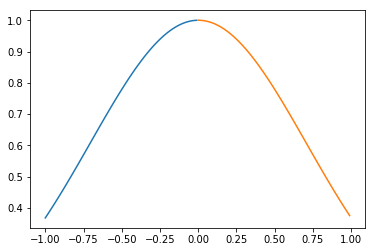

In [57]:
# Load ascii data from a file
data0 = np.genfromtxt("drawgau0.txt")
data1 = np.genfromtxt("drawgau1.txt")
# Plot!
plt.figure()
plt.plot(data0[:,0],data0[:,1])
plt.plot(data1[:,0],data1[:,1])
plt.show()

In [58]:
!jobs-pems-list ${JOB_ID}

stevenrbrandt READ WRITE 


In [59]:
# permissions: READ, WRITE, READ_WRITE, ALL, NONE
!jobs-pems-update -u ktraxler -p READ ${JOB_ID}

Successfully updated permission for ktraxler


In [60]:
!jobs-pems-list ${JOB_ID}

stevenrbrandt READ WRITE 
ktraxler READ 


In [61]:
!apps-pems-list ${APP_NAME}-1.0

stevenrbrandt READ WRITE EXECUTE 
ktraxler READ EXECUTE 
stevenrbrandt READ WRITE EXECUTE 


In [62]:
# permissions: READ, WRITE, EXECUTE, READ_WRITE, READ_EXECUTE, WRITE_EXECUTE, ALL, and NONE
!apps-pems-update -u ktraxler -p READ_EXECUTE ${APP_NAME}-1.0

Successfully updated permission for ktraxler


In [63]:
!apps-pems-list ${APP_NAME}-1.0

stevenrbrandt READ WRITE EXECUTE 
ktraxler READ EXECUTE 
stevenrbrandt READ WRITE EXECUTE 


In [64]:
!echo Click the link to submit and run a job
!echo https://togo.agaveapi.co/app/#/apps/${APP_NAME}-1.0/run

Click the link to submit and run a job
https://togo.agaveapi.co/app/#/apps/drawgau-shelob-stevenrbrandt-1.0/run
